## 연합뉴스 타이틀 주제 분류
* 데이터셋 출처 : 
    * [뉴스 토픽 분류 AI 경진대회 - DACON](https://dacon.io/competitions/official/235747/overview/description)

## 기초 분류 모델 만들기

* 데이터 로드
* 데이터 전처리
* 단어 벡터화(BOW, TF-IDF)
* 분류기 설정하기
* 분류기로 학습시키기
* 학습의 정확도 보기
* 테스트 데이터 예측하기
* 실제 데이터와 예측결과의 차이를 보기

<img src="https://i.imgur.com/Sxm12BY.png" width="900">



## 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 시각화를 위한 폰트 설정

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

<AxesSubplot:title={'center':'한글'}>

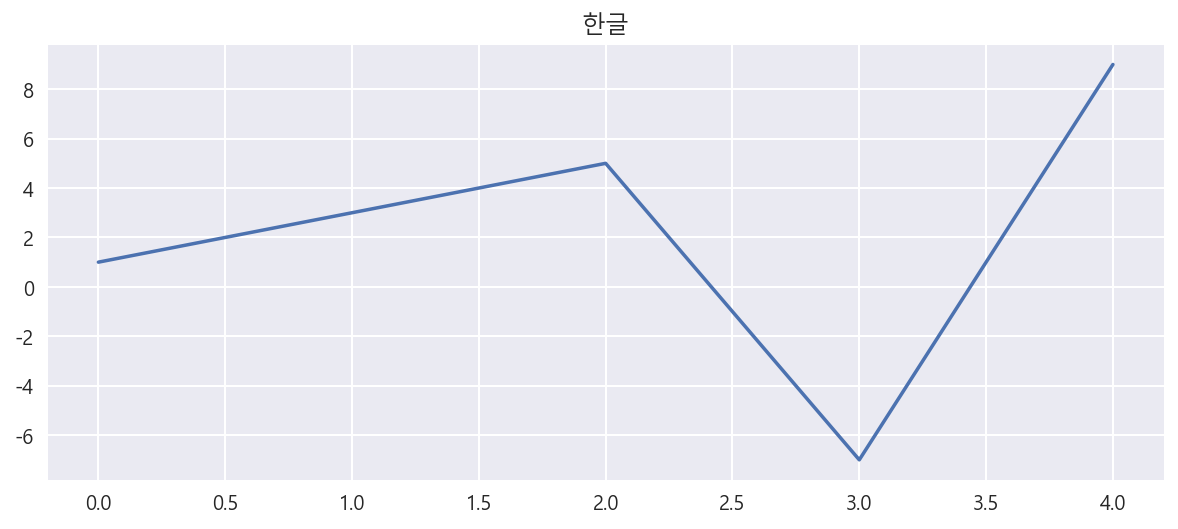

In [3]:
pd.Series([1, 3, 5, -7, 9]).plot(title="한글", figsize=(10, 4))

## 데이터 로드

In [4]:
import os
base_dir = "data/News Topic Classification"

In [5]:
# 학습, 예측 데이터셋을 불러옵니다.
train = pd.read_csv(os.path.join(base_dir, "train_data.csv"))
test = pd.read_csv(os.path.join(base_dir, "test_data.csv"))
train.shape, test.shape

((45654, 3), (9131, 2))

In [6]:
# 토픽을 불러옵니다.
topic = pd.read_csv(os.path.join(base_dir, "topic_dict.csv"))
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## 전처리를 위한 데이터 병합
* 학습, 예측 세트를 똑같이 전처리 해주기 위해 각각 같은 방법을 적용해 줄 수도 있지만
* 두 데이터를 병합해서 전처리를 해주고 다시 나눠주겠습니다.

## concat
<img src="https://pandas.pydata.org/docs/_images/08_concat_row.svg" width="500">

In [8]:
# 전처리를 위해 데이터 병합
df = pd.concat([train,test])
df.shape

(54785, 3)

## 정답값 빈도수
* train 에서 제공하는 정답값의 빈도수

In [18]:
# 정답값 빈도수를 확인합니다.
topic_count = train['topic_idx'].value_counts().sort_values()
topic_count

0    4824
3    5933
1    6222
6    6751
5    6933
2    7362
4    7629
Name: topic_idx, dtype: int64

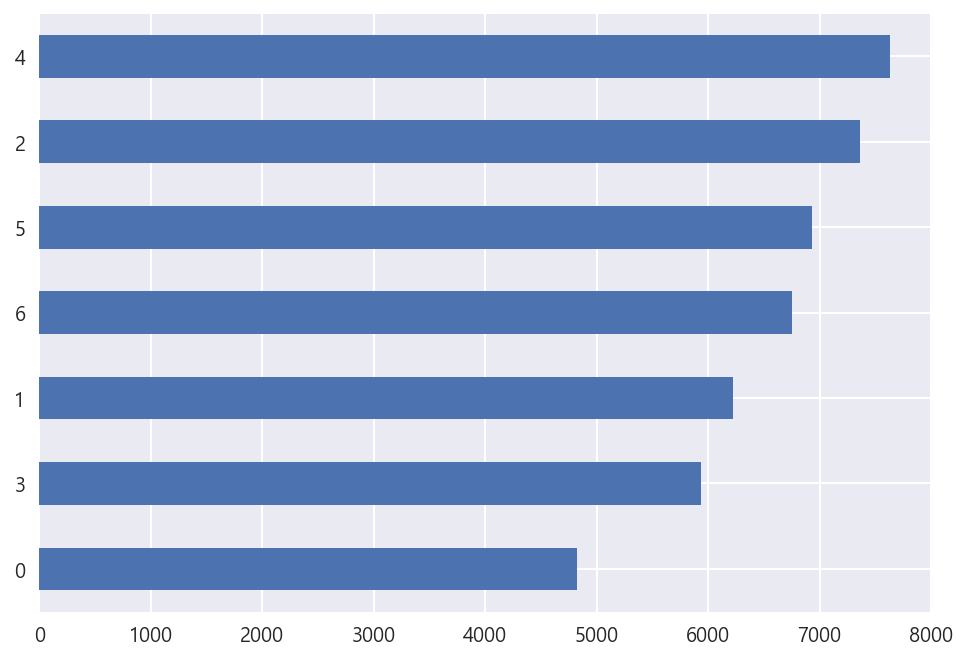

In [19]:
# 정답값 빈도수를 시각화 합니다.
_ = topic_count.plot.barh()

## 문자 전처리

In [20]:
# 정규표현식
import re

def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub('[\s]+', ' ', text)
    # 영문자를 소문자로 만듭니다.
    text = text.lower()
    return text

In [22]:
# map을 통해 전처리 일괄 적용
df["title"] = df["title"].map(preprocessing)
df["title"]

0               인천 핀란드 항공기 결항 휴가철 여행객 분통
1            실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2         이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3       nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4              시진핑 트럼프에 중미 무역협상 조속 타결 희망
                      ...               
9126             인천 오후 시 분 대설주의보 눈 cm 쌓여
9127       노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128           년 전 부마항쟁 부산 시위 사진 점 최초 공개
9129       게시판 아리랑tv 아프리카개발은행 총회 개회식 생중계
9130     유영민 과기장관 강소특구는 지역 혁신의 중심 지원책 강구
Name: title, Length: 54785, dtype: object

### 불용어 제거

In [24]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다', 
             '그리고', '입니다', '그', '등', '이런', '및','제', '더']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [25]:
df["title"] = df["title"].map(remove_stopwords)
df["title"]

0               인천 핀란드 항공기 결항 휴가철 여행객 분통
1            실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2         이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3       nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4              시진핑 트럼프에 중미 무역협상 조속 타결 희망
                      ...               
9126             인천 오후 시 분 대설주의보 눈 cm 쌓여
9127       노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128           년 전 부마항쟁 부산 시위 사진 점 최초 공개
9129       게시판 아리랑tv 아프리카개발은행 총회 개회식 생중계
9130     유영민 과기장관 강소특구는 지역 혁신의 중심 지원책 강구
Name: title, Length: 54785, dtype: object

## 학습, 예측 데이터셋 분리
* 전처리가 되었다면 concat 으로 합쳐주었던 데이터프레임을 다시 학습과 예측 데이터셋으로 분리합니다.

In [28]:
# 정답값으로 사용할 topic_idx 를 변수에 담아 재사용 합니다.
label_name = df['topic_idx']

In [30]:
# label_name 을 기준으로 학습, 예측 세트를 분리합니다.
# label_name 이 있다면 학습 세트, 없다면 예측 세트가 됩니다.
df_train = df[~label_name.isnull()]
df_test = df[label_name.isnull()]

print('df_train.shape :',df_train.shape)
print('df_test.shape :',df_test.shape)

df_train.shape : (45654, 3)
df_test.shape : (9131, 3)


In [31]:
# 학습, 예측에 사용할 문제를 나눕니다.
# 기출문제(X_train)과 실전문제(X_test)를 나눈다고 볼 수 있습니다.
X_train_text = df_train['title']
X_test_text = df_test['title']

In [32]:
# 기출문제의 정답을 만들어 줍니다.
# 잘 나뉘었는지 정닶 값의 빈도수를 확인해 봅니다.
y_train = df_train['topic_idx']

In [34]:
# 테스트의 정답은 모두 결측치 입니다.
# Dacon 사이트에 예측 값을 제출해야 맞고 틀린 갯수를 알 수 있습니다.
y_test = df_test['topic_idx']

## 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### TF-IDF(Term Frequency - Inverse Document Frequency)

정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다. 문서의 핵심어를 추출하거나, 검색 엔진에서 검색 결과의 순위를 결정하거나, 문서들 사이의 비슷한 정도를 구하는 등의 용도로 사용할 수 있다.

TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용 되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \times (\log\big(\frac{N + 1}{N_w + 1}\big) + 1)
\end{equation*}


* 출처 : [tf-idf - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/Tf-idf)

In [ ]:
# TfidfVectorizer 로 벡터화 합니다.
# fit 으로 변환할 어휘를 학습합니다.

# tfidfvect

In [ ]:
# transform
# X_train
# X_test


In [ ]:
# 단어 사전 feature_names


In [ ]:
# np.sum 으로 위에서 구한 TF-IDF 값을 단어별로 더합니다. axis=0 으로 합니다. 

# df_vocab

In [ ]:
# TF-IDF 합계 값이 높은 상위 10개 어휘
# df_vocab

In [ ]:
# 위에서 구한 빈도수를 그래프로 그립니다.


## 모델

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Randomforests_ensemble.gif">

전체 과정
* feature_names : 학습(훈련), 예측에 사용할 단어 사전 입니다.
* label_name : 정답값

* X_train : feature_names 에 해당되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 데이터셋 예) 시험의 기출문제

* X_test : feature_names 에 해당되는 컬럼만 test에서 가져옵니다.
    * 예측에 사용할 데이터셋 예) 실전 시험문제

* y_train : label_name 에 해당 되는 컬럼만 train에서 가져옵니다.
    * 학습(훈련)에 사용할 정답 값 예) 기출문제의 정답

* model : 학습, 예측에 사용할 머신러닝 알고리즘

* model.fit(X_train, y_train) : 학습(훈련), 기출문제와 정답을 가지고 학습(훈련)하는 과정과 유사합니다.

* model.predict(X_test) :  예측, 실제 시험을 보는 과정과 유사합니다. => 문제를 풀어서 정답을 구합니다.

* score
    * 시험을 봤다면 몇 문제를 맞고 틀렸는지 채점해 봅니다.
* metric
    * 점수를 채점하는 공식입니다. (예를 들어 학교에서 중간고사를 봤다면 전체 평균을 계산해 줍니다.)


In [ ]:
# RandomForestClassifier 를 불러옵니다.


## 교차 검증

<img src="https://i.imgur.com/x9M8zpI.png" width="600">

In [ ]:
# cross_val_predict 로 교차 검증을 합니다.


### 교차 검증 정확도

In [ ]:
# 교차 검증 결과 


In [ ]:
# 교차 검증 결과 점수를 구해봅니다.
# 모의고사를 보고 채점해 보는 과정과 유사합니다.
# valid_accuracy

In [ ]:
# df_accuracy 로 정답여부 컬럼을 만듦
# df_accuracy

In [ ]:
# groupby 로 분류별 정확도를 구합니다.
# df_group_accuracy

## 학습

In [ ]:
# fit 으로 학습시킵니다.


## 예측

In [ ]:
# 실전 시험과 유사합니다. 정답 없이 문제만 넣고 풀어서 예측합니다.
# predict로 예측합니다. 
# y_predict

## 정답값 로드

In [ ]:
# sample_submission 파일을 불러옵니다.
# Dacon 에 제출할 답안지 양식입니다.

submit = pd.read_csv(os.path.join(base_dir, "sample_submission.csv"))
submit.head()

In [ ]:
# 정답값 측정을 위해 y_test 변수에 할당
# submit["topic_idx"]

In [ ]:
file_name = f"{base_dir}/submit_{valid_accuracy}.csv"
file_name

In [ ]:
# 파일로 저장합니다.


In [ ]:
# 잘 저장이 되었는지 확인합니다.


* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경